In [2]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import re
import plotly.express as px
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRFClassifier
from sklearn.ensemble import RandomForestClassifier



df_train = pd.read_csv('./input/train.csv', index_col='PassengerId')
df_test = pd.read_csv('./input/test.csv', index_col='PassengerId')

df_complete = pd.DataFrame(df_train.drop(['Survived'], axis=1)).append(df_test)

df_test['LastName']  = df_test.Name.str.split(',').str[0]
df_train['LastName']  = df_train.Name.str.split(',').str[0]
df_complete['LastName']  = df_complete.Name.str.split(',').str[0]

def extract_title(r):
    if re.search('[mMrR]{2}\.', r.Name):
        return 'MR'
    if re.search('[mMiIsSsS]{4}\.', r.Name):
        return 'MISS'
    if re.search('[mMrRsS]{3}\.', r.Name):
        return 'MRS'
    if re.search('[mMaAsStTeErR]{5}\.', r.Name):
        return 'MASTER'
    if re.search('[dDrR]{2}\.', r.Name):
        return 'DR'
    if re.search('[rReEvV]{3}\.', r.Name):
        return 'REV'
    return 'OTHER'

df_train['Title'] = df_train.apply(lambda r : extract_title(r) , axis = 1)
df_complete['Title'] = df_complete.apply(lambda r : extract_title(r) , axis = 1)
df_test['Title'] = df_test.apply(lambda r : extract_title(r) , axis = 1)

def extract_ticket_info_group(ticket):
    regex = re.search('(.+) ([0-9]{1,7})$', ticket)
    if regex is not None:
        return regex.group(1)
    return np.nan

def extract_ticket_number(ticket):
    regex = re.search('(.+) ([0-9]{1,7})$', ticket)
    if regex is not None:
        return regex.group(2)
    return ticket

df_train['ticket_group'] = df_train.apply(lambda r : extract_ticket_info_group(r.Ticket) , axis = 1)
df_complete['ticket_group'] = df_complete.apply(lambda r : extract_ticket_info_group(r.Ticket) , axis = 1)
df_test['ticket_group'] = df_test.apply(lambda r : extract_ticket_info_group(r.Ticket) , axis = 1)

df_train['ticket_number'] = df_train.apply(lambda r : extract_ticket_number(r.Ticket) , axis = 1)
df_complete['ticket_number'] = df_complete.apply(lambda r : extract_ticket_number(r.Ticket) , axis = 1)
df_test['ticket_number'] = df_test.apply(lambda r : extract_ticket_number(r.Ticket) , axis = 1)

# Configure label encoders
le_sex = preprocessing.LabelEncoder()
le_sex.fit(df_complete['Sex'])

le_ticket_group = preprocessing.LabelEncoder()
le_ticket_group.fit(df_complete['ticket_group'].dropna())

le_section = preprocessing.LabelEncoder()
section = df_complete.apply(lambda row : None if pd.isnull(row.Cabin) else row.Cabin[0] , axis=1).dropna().unique()
le_section.fit(section) 

le_embarked = preprocessing.LabelEncoder()
embarked = df_complete.apply(lambda row : None if pd.isnull(row.Embarked) else row.Embarked , axis=1).dropna().unique()
le_embarked.fit(embarked) 

le_lastname = preprocessing.LabelEncoder()
le_lastname.fit(df_complete['LastName']) 

le_title = preprocessing.LabelEncoder()
le_title.fit(df_complete['Title']) 


survialByTitle = df_train[['Title','Survived']].where(df_train.Survived==True).groupby(['Title']).agg(['count']) / df_train[['Title','Survived']].where(df_train.Survived==False).groupby(['Title']).agg(['count'])    

personsPerLastName = df_complete.LastName.groupby(df_complete.LastName).count().to_dict()

family = df_train.groupby(df_train.LastName).Survived  
d = family.apply(list)

# Estimate age
lr_age = LinearRegression()
df_age = df_complete[['Pclass', 'Title', 'SibSp', 'Age']].dropna()

df_age['Title'] = df_age.apply(lambda row : pd.NA if pd.isnull(row.Title) else le_title.transform([row.Title])[0], axis = 1)
lr_age.fit(df_age[['Pclass', 'Title', 'SibSp']], df_age['Age'])

# Estimate missing sections
lr_section = LinearRegression()
df_section = df_complete[['Pclass', 'Fare','Embarked', 'Cabin']].dropna()
df_section['Section'] = df_section.apply(lambda row : pd.NA if pd.isnull(row.Cabin) else le_section.transform([row.Cabin[0]])[0] , axis=1)
df_section['Embarked'] = df_section.apply(lambda row : pd.NA if pd.isnull(row.Embarked) else le_embarked.transform([row.Embarked])[0] , axis=1)

clf_section = RandomForestClassifier()
clf_section.fit(df_section.dropna()[['Pclass', 'Fare', 'Embarked']], df_section['Section'])

# Estimate missing Fares
lr_fare = LinearRegression()
fare_df = df_complete[['Pclass', 'Embarked', 'Fare']].dropna()
fare_df['Embarked'] = fare_df.apply(lambda row : pd.NA if pd.isnull(row.Embarked) else le_embarked.transform([row.Embarked])[0] , axis=1)
lr_fare.fit(fare_df[['Pclass', 'Embarked']], fare_df['Fare'])


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [5]:
# personsPerLastName = df_complete.LastName.groupby(df_complete.LastName).count().to_dict()

# family = df_train.groupby(df_train.LastName).Survived  
# d = family.apply(list)

# m = {}
# for k, v in d.to_dict().items():
#     m[k] = sum(v) / personsPerLastName[k]

# df_test['SurvivalRateByLastName'] =df_test.apply(lambda r :  m[r['LastName']] if r['LastName'] in m else 0 , axis =1)
# df_train['SurvivalRateByLastName'] = df_train.apply(lambda r :  m[r['LastName']] if r['LastName'] in m else 0 , axis =1)
# df_complete['SurvivalRateByLastName'] = df_complete.apply(lambda r :  m[r['LastName']] if r['LastName'] in m else 0 , axis =1)

In [3]:
def prepare(df):
    df['Embarked'] = df['Embarked'].fillna(method='ffill')
    df['Sex'] = le_sex.transform(df.Sex)
    df['Fare'] = df.apply(lambda row : lr_fare.predict([[row.Pclass, row.Parch]])[0] if pd.isna(row.Fare) else row.Fare , axis=1)
    df['Embarked'] = le_embarked.transform(df.Embarked)

    # df['SurvivalByTitle'] = df.apply(lambda row : survialByTitle.loc[row.Title,:][0] , axis=1)
    # df['SurvivalByTitle'] = df.apply(lambda row: 0 if pd.isna(row.SurvivalByTitle) else row.SurvivalByTitle, axis =1)
    df['Title'] = le_title.transform(df.Title)
    df['Age'] = df.apply(lambda row : lr_age.predict([[row.Pclass, row.Title, row.SibSp]])[0] if pd.isna(row.Age) else row.Age, axis=1)
    df['Single'] = df.apply(lambda row : 1 if personsPerLastName[row.LastName] == 1 else 0, axis=1)
    df['LastName'] =  le_lastname.transform(df.LastName)
    df['Section'] = df.apply(lambda row : clf_section.predict([[row.Embarked, row.Fare, row.Pclass]])[0] if pd.isnull(row.Cabin) else le_section.transform([row.Cabin[0]])[0] , axis=1)
    df['ticket_group'] = df.apply(lambda row : -1 if pd.isna(row.ticket_group) else le_ticket_group.transform([row.ticket_group])[0] , axis=1) 
    df['ticket_number'] = pd.to_numeric( df.apply(lambda row : 0 if row.ticket_number == 'LINE' else row.ticket_number , axis=1))

    return df.drop(columns=['Name', 'Ticket', 'Cabin'], axis=1)

df_train = prepare(df_train)
df_test = prepare(df_test)
df_complete = prepare(df_complete)    
target = df_train['Survived']

PassengerId
1       21171
2       17599
3     3101282
4      113803
5      373450
6      330877
7       17463
8      349909
9      347742
10     237736
Name: ticket_number, dtype: int64

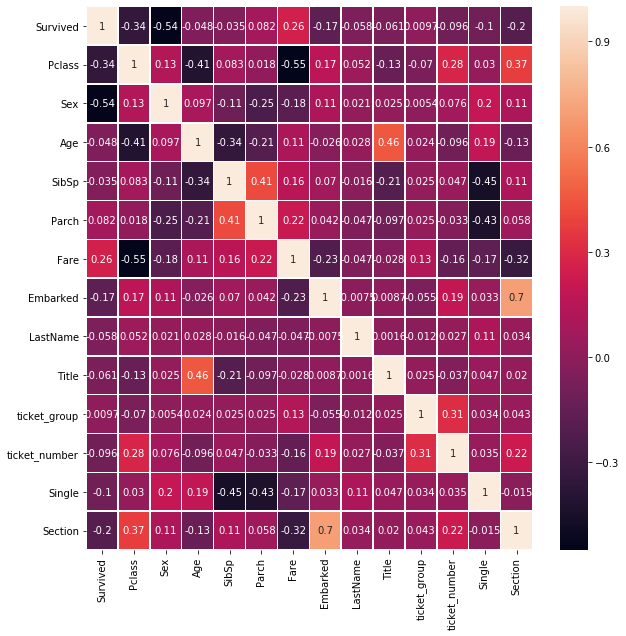

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots(figsize=(10,10)) 
sns.heatmap(df_train.corr(), annot=True,linewidths=.5, ax=ax)

In [19]:
import plotly.express as px
fig = px.scatter(x=df_complete['SibSp'], y=df_complete['Age'])
fig.show()

In [56]:
selected_features = ['Pclass', 'Sex', 'Fare', 'Embarked', 'Single']

In [5]:
from sklearn.linear_model import LassoCV
from sklearn.feature_selection import SelectFromModel

X_selection = df_train

# Set a minimum threshold of 0.25
sfm = SelectFromModel(LassoCV(), threshold=0.25)
sfm.fit(X_selection, target)


print(sfm.get_support())
selected_features = X_selection.columns[(sfm.get_support())]

print(selected_features)

[False False False False False False False False False False False False
 False False]
Index([], dtype='object')


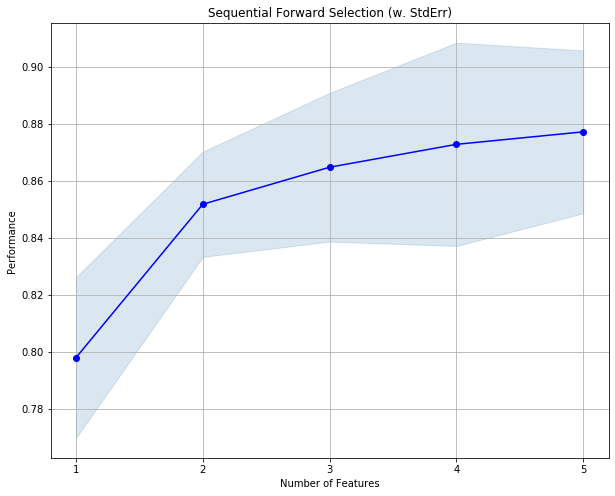

['Pclass', 'Fare', 'Section', 'Title', 'ticket_number']


In [23]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import matplotlib.pyplot as plt

X_selection = df_train[['Pclass', 'Sex', 'Age', 'SibSp','Parch', 'Fare', 'Section', 'Single', 'LastName', 'Title', 'ticket_group', 'ticket_number']]

xgbc_fs = XGBClassifier()
sfs = SFS(estimator=xgbc_fs,
           k_features=5,
           cv=5,
           scoring='roc_auc',
           forward=True)
     

sfs.fit(X_selection, target)

fig1 = plot_sfs(sfs.get_metric_dict(), kind='std_dev', figsize=(10, 8))
plt.title('Sequential Forward Selection (w. StdErr)')
plt.grid()
plt.show()
selected_features = list(sfs.k_feature_names_)
print(selected_features)

In [24]:
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
# You can experiment with many other options here, using the same .fit() and .predict()
# methods; see http://scikit-learn.org
# This example uses the current build of XGBoost, from https://github.com/dmlc/xgboost

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(df_complete[selected_features])

X_train, X_test, y_train, y_test = train_test_split(scaler.transform(df_train[selected_features]), target, test_size=0.2, random_state=42)
# X_train = scaler.transform(X_train)

# X_test = scaler.transform(X_test)
eval_set = [(X_test, y_test)]
gbm = XGBRFClassifier(random_state=42, eval_metric="logloss", eval_set=eval_set, num_round = 2)
# gbm = XGBClassifier()

params = {
     'nthread':[4],
      'n_estimators' :[2, 3,5,8,16,32,64,128],
      'learning_rate': [0.2, 0.1, 0.05],
      'max_depth' : [3,4,5,6, 8],
      'objective':['binary:logistic'],
      'seed': [1337],
      'min_child_weight': [7, 11, 15, 20],
      }
# params = {'nthread':[4], #when use hyperthread, xgboost may become slower
#               'objective':['binary:logistic'],
#               'learning_rate': [0.05], #so called `eta` value
#               'max_depth': [3,4,5,6, 8, 9, 10, 12, 15],
#               'min_child_weight': [1, 3, 7, 11, 15, 20],
#               'silent': [1],
#               'subsample': [0.8],
#               'colsample_bytree': [0.7],
#               'n_estimators': [3,5,8,10,16,32, 64, 256, 500, 1000], #number of trees, change it to 1000 for better results
#               'missing':[-999],
#               'seed': [1337]}

clf = GridSearchCV(gbm, params, n_jobs=5,
                   cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=7),
                   scoring='roc_auc',
                   verbose=2, refit=True)

clf.fit(X_train, y_train)

predictions = clf.best_estimator_.predict(X_train)
predictions_test = clf.best_estimator_.predict(X_test)

print(classification_report(y_train, predictions))
print(classification_report(y_test, predictions_test))

Fitting 5 folds for each of 480 candidates, totalling 2400 fits
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:    3.2s
[Parallel(n_jobs=5)]: Done 468 tasks      | elapsed:   10.5s
[Parallel(n_jobs=5)]: Done 1280 tasks      | elapsed:   24.1s
              precision    recall  f1-score   support

           0       0.83      0.91      0.87       444
           1       0.82      0.70      0.76       268

    accuracy                           0.83       712
   macro avg       0.83      0.80      0.81       712
weighted avg       0.83      0.83      0.83       712

              precision    recall  f1-score   support

           0       0.81      0.83      0.82       105
           1       0.75      0.72      0.73        74

    accuracy                           0.78       179
   macro avg       0.78      0.77      0.77       179
weighted avg       0.78      0.78      0.78       179

[Parallel(n_jobs=5)]: D

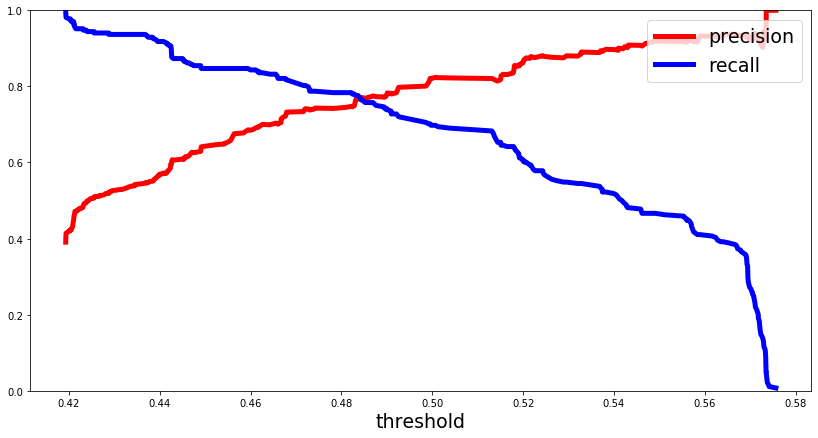

ROC-AUC-Score: 0.8788237864730402


In [25]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
y_scores = clf.best_estimator_.predict_proba(X_train)
y_scores = y_scores[:,1]


precision, recall, threshold = precision_recall_curve(y_train, y_scores)
def plot_precision_and_recall(precision, recall, threshold):
    plt.plot(threshold, precision[:-1], "r-", label="precision", linewidth=5)
    plt.plot(threshold, recall[:-1], "b", label="recall", linewidth=5)
    plt.xlabel("threshold", fontsize=19)
    plt.legend(loc="upper right", fontsize=19)
    plt.ylim([0, 1])

plt.figure(figsize=(14, 7))
plot_precision_and_recall(precision, recall, threshold)
plt.show()

r_a_score = roc_auc_score(y_train, y_scores)
print("ROC-AUC-Score:", r_a_score)

In [26]:

submission = pd.DataFrame(df_test.index.values, columns=['PassengerId'])
submission_predictions = clf.best_estimator_.predict(scaler.transform(df_test[selected_features]))
submission['Survived'] = submission_predictions
submission.to_csv('submission.csv', index=False)